In [11]:
!nvidia-smi

Fri Dec 11 09:16:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    40W / 300W |   1261MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
import random
 
import torch.nn as nn
import torch.nn.functional as F
 
import time

# 0-1. Set Hyper Parameters (Model1)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trial = 35
# Hyper parameters
batch_size = 128
num_epochs = 6

num_classes = 2
out1 = 64
kernel = 5
padding = 2
out2 = 128
out3 = 512
out4 = 64
drop1 = 0
drop2 = 0
out5 = 256
drop3 = 0

# 1-1. Load Data (Model1)

In [14]:
class TypeData(Dataset):
  '''
### Digit일 경우 label로 0을, ###
### Letter일 경우 label로 1을 ###
### return하는 class입니다. ###
사용 예시:
train_data = TypeData(train=True)
test_data = TypeData(train=False)
  '''
  def __init__(self,train):
    super(TypeData, self).__init__()
    self.digit = 10
    self.letter = 46
    self.train = train

    self.data = torchvision.datasets.EMNIST(root='./',
                                        split='bymerge',
                                        train=self.train,
                                        transform=transforms.Compose([transforms.ToTensor()]),
                                        download=True)

  def __getitem__(self, index):
    if self.data[index][1] < self.digit:
      label = 0.
    else:
      label = 1.
    return self.data[index][0], label

  def __len__(self):
    return len(self.data)

In [15]:
dataset = TypeData(train=True)
train_data, val_data = torch.utils.data.random_split(dataset, [int(len(dataset)*0.9)+1, int(len(dataset)*0.1)])
test_data = TypeData(train=False)

# 2-1. Define DataLoader

In [16]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_data,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=batch_size,
                                          shuffle=False)

# 3-1. Define Model1

In [17]:
class Model1(nn.Module):
  def __init__(self, num_classes, out1, kernel, padding, out2, out3, out4, drop1, drop2, out5, drop3):
    super(Model1, self).__init__()
    self.num_classes = num_classes
    self.out1 = out1
    self.kernel = kernel
    self.padding = padding
    self.out2 = out2
    self.out3 = out3
    self.out4 = out4
    self.drop1 = drop1
    self.drop2 = drop2
    self.out5 = out5
    self.drop3 = drop3

    self.cnn1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=out1, kernel_size=kernel+4, stride=1, padding=padding+2),
        nn.Dropout(drop1),
        nn.BatchNorm2d(out1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )

    self.cnn2 = nn.Sequential(
        nn.Conv2d(in_channels=out1, out_channels=out2, kernel_size=kernel, stride=1, padding=padding),
        nn.Dropout(drop2),
        nn.BatchNorm2d(out2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )

    self.cnn3 = nn.Sequential(
        nn.Conv2d(in_channels=out2, out_channels=out5, kernel_size=kernel-2, stride=1, padding=padding-1),
        nn.Dropout(drop3),
        nn.BatchNorm2d(out5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    
    # compute image size after max pooling
    def downsize(input_size, padding, kernel):
      return (input_size+(padding*2)-kernel+1)//2
    s = downsize(28, padding+2, kernel+4) # image size after max pooling of CNN1
    s = downsize(s, padding, kernel) # image size after max pooling of CNN2
    s = downsize(s, padding-1, kernel-2) # image size after max pooling of CNN3
    self.fc1 = nn.Sequential(
        nn.Linear(s*s*out5, out3),
        nn.BatchNorm1d(out3)
    )
    self.fc2 = nn.Sequential(
        nn.Linear(out3, out4),
        nn.BatchNorm1d(out4)
    )
    self.fc3 = nn.Linear(out4, 1)

  def forward(self, x):
    # comment: tensor size after passing trough each layer
    x = self.cnn1(x) # 128x64x14x14(batch size x num output x wide x height)
    x = self.cnn2(x) # 128x128x7x7 (batch size x num output x wide x height)
    x = self.cnn3(x) # 128x256x3x3
    x = x.reshape(x.size(0), -1) # 128x(256x3x3) (batch size x (num output x wide x height))
    x = F.relu(self.fc1(x)) # 128x512 (batch size x num output)
    x = F.relu(self.fc2(x)) # 128x64 (batch size x num output)
    x = torch.sigmoid(self.fc3(x)) # 128x1 (batch size x num output)
    return x

In [ ]:
model1 = Model1(num_classes, out1, kernel, padding, out2, out3, out4, drop1, drop2, out5, drop3).to(device)

In [ ]:
print(model1)

Model1(
  (cnn1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): Dropout(p=0, inplace=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Dropout(p=0, inplace=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Dropout(p=0, inplace=False)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1)

# 4-1. Define Loss / Optimizer (Model1)

In [ ]:
learning_rate = 0.0006

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate)

# 5-1. Train (Model1)

In [ ]:
print(f'시행 {trial} train')
t1 = time.time()

train_loss_list = []
train_accuracy_list = []
validation_loss_list = []
validation_accuracy_list = []

for epoch in range(num_epochs):
  running_loss = 0
  right = 0 # the number of right prediction
  for i, (img, lbl) in enumerate(train_loader):
    img = img.to(device)
    lbl = lbl.reshape(lbl.size(0),1).float().to(device)

    # Forward
    out = model1(img).to(device)

    # Get Loss / Compute Gradient / Update Parameters
    loss = criterion(out, lbl)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # sum training loss and right prediction
    running_loss += loss.item()
    right += (torch.round(out)==lbl).sum().item()

    # validation checking for end of each epoch
    if (i+1)==len(train_loader):

      # Compute Train Accuracy and Loss
      train_acc = right/len(train_data) # mean of right prediction
      train_loss = running_loss/len(train_loader) # mean of running loss

      # Compute Validation Loss & Accuracy
      with torch.no_grad():
        val_right = 0
        val_loss = 0
        for v, (val_img, val_lbl) in enumerate(val_loader):
          val_img = val_img.to(device)
          val_lbl = val_lbl.reshape(val_lbl.size(0),1).float().to(device)

          val_out = model1(val_img)
          val_loss += criterion(val_out, val_lbl).item()

          val_pred = torch.round(val_out)
          val_right += (val_pred==val_lbl).sum().item()
        val_loss = val_loss / len(val_loader)
        val_acc = val_right / len(val_data)
      
      # Check Loss & Accuracy
      print(f'Epoch: [{epoch+1}/{num_epochs}] Step: [{i+1}/{len(train_loader)}], ', end='')
      print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc*100:.4f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc*100:.4f}%', end=' ')
      print(f'걸린 시간: {time.time()-t1:.4f}초')
  train_loss_list.append(train_loss)
  train_accuracy_list.append(train_acc)
  validation_loss_list.append(val_loss)
  validation_accuracy_list.append(val_acc)

t2 = time.time()
print(f'걸린 시간: {t2-t1:.4f}초')

시행 35 train
Epoch: [1/6] Step: [4908/4908], Train Loss: 0.1959, Train Accuracy: 91.1679%, Validation Loss: 0.1702, Validation Accuracy: 92.2700% 걸린 시간: 140.8934초
Epoch: [2/6] Step: [4908/4908], Train Loss: 0.1654, Train Accuracy: 92.4692%, Validation Loss: 0.1642, Validation Accuracy: 92.5465% 걸린 시간: 281.8027초
Epoch: [3/6] Step: [4908/4908], Train Loss: 0.1564, Train Accuracy: 92.8516%, Validation Loss: 0.1595, Validation Accuracy: 92.8102% 걸린 시간: 423.7344초
Epoch: [4/6] Step: [4908/4908], Train Loss: 0.1497, Train Accuracy: 93.1267%, Validation Loss: 0.1560, Validation Accuracy: 92.9019% 걸린 시간: 565.7091초
Epoch: [5/6] Step: [4908/4908], Train Loss: 0.1438, Train Accuracy: 93.3733%, Validation Loss: 0.1598, Validation Accuracy: 92.6683% 걸린 시간: 707.6412초
Epoch: [6/6] Step: [4908/4908], Train Loss: 0.1389, Train Accuracy: 93.5618%, Validation Loss: 0.1565, Validation Accuracy: 92.9678% 걸린 시간: 851.0220초
걸린 시간: 851.0222초


## 5-1-2. Plot Accuracy & Loss

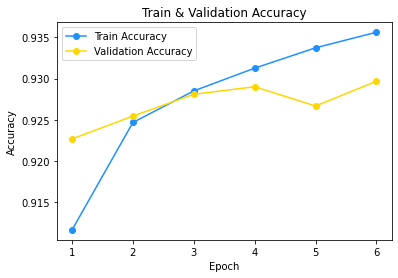

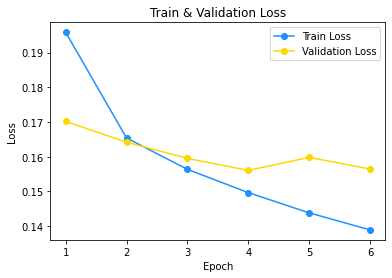

In [ ]:
plt.plot(np.arange(1, num_epochs+1), train_accuracy_list, 
         label='Train Accuracy', marker='o', color='dodgerblue')
plt.plot(np.arange(1, num_epochs+1), validation_accuracy_list, 
         label='Validation Accuracy', marker='o', color='gold')
plt.legend()
plt.title('Train & Validation Accuracy')
plt.xlabel('Epoch')
plt.xticks(ticks=np.arange(1,num_epochs+1), label=np.arange(1,num_epochs+1))
plt.ylabel('Accuracy')
# plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/모델1/accuracy_{trial}.png')
plt.show()

plt.plot(np.arange(1, num_epochs+1), train_loss_list, 
         label='Train Loss', marker='o', color='dodgerblue')
plt.plot(np.arange(1, num_epochs+1), validation_loss_list, 
         label='Validation Loss', marker='o', color='gold')
plt.legend()
plt.title('Train & Validation Loss')
plt.xlabel('Epoch')
plt.xticks(ticks=np.arange(1,num_epochs+1), label=np.arange(1,num_epochs+1))
plt.ylabel('Loss')
plt.title('Train & Validation Loss')
# plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/모델1/loss_{trial}.png')
plt.show()

# 6-1. Test (Model1)

In [ ]:
test_acc = 0
with torch.no_grad():
  for i, (img, lbl) in enumerate(test_loader):
    img = img.to(device)
    lbl = lbl.reshape(lbl.size(0), 1).float().to(device)

    pred = model1(img)
    pred = torch.round(pred)

    test_acc += (pred==lbl).sum().item() / len(lbl)
  test_acc /= len(test_loader)
  print(f'Test Accuracy of Model1 on the {len(test_data)} images: {test_acc*100:.2f}%')

Test Accuracy of Model1 on the 116323 images: 93.05%


# 7-1. Save Model1

In [ ]:
torch.save(model1.state_dict(), 'model1.pth')

# 8-1. Load Model1

In [18]:
# 시행35 최종 선정 model hyper parameters
batch_size = 128
num_classes = 2
out1 = 64
kernel = 5
padding = 2
out2 = 128
out3 = 512
out4 = 64
drop1 = 0
drop2 = 0
out5 = 256
drop3 = 0

loaded_model1 = Model1(num_classes, out1, kernel, padding, out2, out3, out4, drop1, drop2, out5, drop3).to(device)
loaded_model1.load_state_dict(torch.load('model1.pth'))

<All keys matched successfully>

# 9-1. Test with Loaded Model1

In [19]:
test_acc = 0
with torch.no_grad():
  for i, (img, lbl) in enumerate(test_loader):
    img = img.to(device)
    lbl = lbl.reshape(lbl.size(0), 1).float().to(device)

    pred = loaded_model1(img)
    pred = torch.round(pred)

    test_acc += (pred==lbl).sum().item() / len(lbl)
  test_acc /= len(test_loader)
  print(f'Test Accuracy of Model1 on the {len(test_data)} images: {test_acc*100:.2f}%')

Test Accuracy of Model1 on the 116323 images: 93.05%
